In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import io
import time
import torch
import torchaudio

In [ ]:
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import fastprogress
import numpy as np
import pylab as plt
import pandas as pd
import random
import IPython

import whisper

from fastcore.script import *
from whisperspeech.wer_metrics import *

# VQ semantic token extraction evaluation

## How Whisper works with speech cut at different lengths

In [ ]:
def test_incremental(model_name, Tmax=15):
    whmodel = whisper.load_model(model_name)
    for i in range(Tmax):
        print(i, whmodel.transcribe(snd[0,:int(i*16000)])['text'])

In [ ]:
test_incremental('tiny.en')

0 
1  Chapter
2  Chapter 5 of the
3  Chapter 5 of the things in our garden.
4  Chapter 5 of the Things in Our Garden by Arthur Rachael.
5  Chapter 5 of the things in our garden by Arthur Ransom.
6  Chapter 5 of the Things in Our Garden by Arthur Ransom. This LibraVox Recordings.
7  Chapter 5 of the Things in Our Garden by Arthur Ransom. This LibraVox recording is in the public.
8  Chapter 5 of the Things in Our Garden by Arthur Ransom. This LibraVox recording is in the public domain.
9  Chapter 5 of the Things in Our Garden by Arthur Ransom. This LibraVox recording is in the public domain. Chapter 5
10  Chapter 5 of the Things in Our Garden by Arthur Ransom. This LibraVox recording is in the public domain. Chapter 5, their own garden.
11  Chapter 5 of the Things in Our Garden by Arthur Ransom. This LibraVox recording is in the public domain. Chapter 5, Their Own Gardens.
12  Chapter 5 of the Things in Our Garden by Arthur Ransom. This Libra-Vox recording is in the public domain. Chapte

In [ ]:
test_incremental('base.en')

0 
1  Chapter 4
2  Chapter 5 of the
3  Chapter 5 of the Things in our Guard.
4  Chapter 5 of The Things in Our Garden by Arthur Raffy
5  Chapter 5 of The Things in Our Garden by Arthur Ransom.
6  Chapter 5 of The Things in Our Garden by Arthur Ransom.
7  CHAPTER V.
8  CHAPTER V.
9  CHAPTER V.
10  CHAPTER V.
11  CHAPTER V.
12  CHAPTER V. Their Own Gardens.
13  CHAPTER V. Their Own Gardens.
14  CHAPTER V.


In [ ]:
test_incremental('large-v2')

0 
1  Chapter 4.
2  Chapter 5 of the
3  Chapter 5 of The Things in Our Garden
4  V. THE THINGS IN OUR GARDEN
5  V. THE THINGS IN OUR GARDEN.
6  CHAPTER V
7  V. THE THINGS IN OUR GARDEN
8  CHAPTER V
9  CHAPTER V
10  V. THEIR OWN GARDEN
11  V. THEIR OWN GARDENS
12  V. THEIR OWN GARDENS
13  V. THEIR OWN GARDENS CLOSE BY THE WOOD
14  V. THEIR OWN GARDENS CLOSE BY THE WOOD AT THE BOTTOM OF THE GARDEN


# Tests on LibriSpeech

In [ ]:
def make_test_ds(): return progress_bar(librispeech_data('/data/LibriSpeech/test-clean'), total=1000)

## Entropy of the token stream

In [ ]:
from whisperspeech.vq_stoks import RQBottleneckTransformer

In [ ]:
import collections
def calc_model_entropy(ds, modelfile):
    vqmodel = RQBottleneckTransformer.load_model(local_filename=modelfile).cuda()
    cnts = collections.Counter()
    for snd,txt in ds:
        stoks = vqmodel.encode_audio(snd.cuda())
        cnts.update(stoks[0].tolist())
    pdf = torch.tensor([cnts[i] for i in range(max(cnts)+1)])
    pdf = pdf / pdf.sum()
    return -torch.nansum(pdf * np.log2(pdf))

In [ ]:
# the original semantic token model from early 2023
calc_model_entropy(make_test_ds(), None)

6.097853445304322

In [ ]:
calc_model_entropy(make_test_ds(), "vq-ce9.2.model")

6.357563112144668

In [ ]:
calc_model_entropy(make_test_ds(), "vq-256c.model")

3.0997004132066834

In [ ]:
calc_model_entropy(make_test_ds(), "vq-256c-cosine.model")

5.6921860685011225

In [ ]:
calc_model_entropy(make_test_ds(), "vq-2d-256c.model")

2.899952018598168

In [ ]:
calc_model_entropy(make_test_ds(), "vq-2d-256c-cosine.model")

5.769594466589709

In [ ]:
calc_model_entropy(make_test_ds(), "vq-2d-256c-cosine-padfix2.model")

7.741530540488036

In [ ]:
calc_model_entropy(make_test_ds(), "vq-2d-512c-cosine-padfix-premlp-learnpos-5e.model")

8.164144580014993

In [ ]:
calc_model_entropy(make_test_ds(), "vq-2d-512c-cosine32-padfix-premlp-learnpos-5e.model")

11.37221612373814

In [ ]:
calc_model_entropy(make_test_ds(), "vq-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.model")

11.240560444030649

In [ ]:
calc_model_entropy(make_test_ds(), "vq-base.en-2d-1024c-cosine32-padfix-premlp-learnpos-5e-cleaned.model")

/tmp/ipykernel_276/107266959.py:11: RuntimeWarning: divide by zero encountered in log2
  return -torch.nansum(pdf * np.log2(pdf))


tensor(9.6971)

In [ ]:
calc_model_entropy(make_test_ds(), "vq-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-cleaned.model")

/tmp/ipykernel_276/107266959.py:11: RuntimeWarning: divide by zero encountered in log2
  return -torch.nansum(pdf * np.log2(pdf))


tensor(11.4108)

In [ ]:
calc_model_entropy(make_test_ds(), "vq-base.en-2d-4096c-cosine32-padfix-premlp-preconv-learnpos-5e-cleaned.model")

/tmp/ipykernel_103351/107266959.py:11: RuntimeWarning: divide by zero encountered in log2
  return -torch.nansum(pdf * np.log2(pdf))


tensor(9.9410)

In [ ]:
calc_model_entropy(make_test_ds(), "vq-base.en-2d-4096c-cosine32-padfix-premlp-premean-learnpos-5e-cleaned.model")

/tmp/ipykernel_9385/107266959.py:11: RuntimeWarning: divide by zero encountered in log2
  return -torch.nansum(pdf * np.log2(pdf))


tensor(11.2880)

In [ ]:
calc_model_entropy(make_test_ds(), "vq-base.en-2d-4096c-60k.model")

tensor(11.4831)

In [ ]:
calc_model_entropy(make_test_ds(), "vq-base.en-2d-4096c-60k.model")

tensor(11.4831)

In [ ]:
# 4096 tokens, we later found out that tokens from this model do carry speaker information
calc_model_entropy(make_test_ds(), "vqmodel-4e-hyptuned-32gpu.model")

tensor(11.6404)

In [ ]:
calc_model_entropy(make_test_ds(), "vqmodel-256c-4e-hyptuned-32gpu.model")

tensor(8.7963)

In [ ]:
calc_model_entropy(make_test_ds(), "vqmodel-256c-dim64-4e-hyptuned-32gpu.model")

tensor(8.7499)

In [ ]:
calc_model_entropy(make_test_ds(), "vqmodel-base-en+pl-512c-dim64.model")

tensor(8.3956)

In [ ]:
# the final model
calc_model_entropy(make_test_ds(), "vqmodel-medium-en+pl-512c-dim64.model")

tensor(8.4314)

## Word Error Rate measurements

In [ ]:
from whisperspeech.wer_metrics import *

### Vanilla Whisper models

In [ ]:
def test_wh_model(whmodel):
    decoding_options=whisper.DecodingOptions(language='en')
    stats = WERStats()
    for snd, gt_text in progress_bar(librispeech_data('/data/LibriSpeech/test-clean'), total=1000):
        text = whmodel.decode(whisper.log_mel_spectrogram(whisper.pad_or_trim(snd[0])).cuda(), decoding_options).text
        diff = stats.push_sample(snd, gt_text, text)
        last_diff = diff.alignments[0][-1]
        stats.push(hallucination = last_diff.type == 'insert' and last_diff.hyp_end_idx - last_diff.hyp_start_idx > 3)
    stats = stats.df().sort_values('wer')
    print(f"WER: {stats.wer.mean()*100:.2f}%")
    print(f"WER (w/o hallucinations): {stats[~stats['hallucination']].wer.mean()*100:.2f}%")
    return stats

In [ ]:
test_wh_model(whisper.load_model('tiny.en'))

WER: 6.91%
WER (w/o hallucinations): 6.91%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, while on her lap...",0.000000,0.000000,0.000000,1.000000,False
355,2.885,None,I'M AFRAID I DON'T KNOW MUCH ABOUT THE LAND OF OZ,I'm afraid I don't know much about the land of...,0.000000,0.000000,0.000000,1.000000,False
353,5.870,None,THE FIRST LOT WE TESTED ON OUR GLASS CAT WHICH...,"The first lot we tested on our glass cat, whic...",0.000000,0.000000,0.000000,1.000000,False
674,2.295,None,HE ONLY SHOOK HIS HEAD,He only shook his head.,0.000000,0.000000,0.000000,1.000000,False
675,11.545,None,WELL BUT NOW SAID THE PRINCESS AND SHE FILLED ...,"Well, but now said the princess, and she fille...",0.000000,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
524,3.195,None,BROTHER MAC ARDLE BROTHER KEOGH,"Brother Maccardo, Brother Keoff.",0.600000,0.600000,0.800000,0.200000,False
592,1.805,None,HANS STIRS NOT,Hans Stairz-Nied.,0.666667,0.666667,0.888889,0.111111,False
820,2.155,None,THE FORMER BOOLOOROO GROANED,The former Billie Rook-Round,0.750000,0.600000,0.800000,0.200000,False
918,3.000,None,THAT IS TRUE BADAUDERIE,That is true bad dealt gree.,0.750000,0.500000,0.625000,0.375000,False


In [ ]:
test_wh_model(whisper.load_model('base.en'))

WER: 5.08%
WER (w/o hallucinations): 5.08%


,secs,gt_text,text,wer,hallucination
0,8.230,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,And often has my mother said while on her lap ...,0.000000,False
403,5.370,DEPARTING FROM FIVE HUNDRED THOUSAND THROATS T...,"Departing from 500,000 throats, three cheers b...",0.000000,False
404,13.140,THOUSANDS OF HANDKERCHIEFS WERE WAVING ABOVE T...,Thousands of handkerchiefs were waving above t...,0.000000,False
405,2.695,IT'S ALMOST BEYOND CONJECTURE,It's almost beyond conjecture.,0.000000,False
406,7.805,THIS REALITY BEGINS TO EXPLAIN THE DARK POWER ...,This reality begins to explain the dark power ...,0.000000,False
...,...,...,...,...,...
524,3.195,BROTHER MAC ARDLE BROTHER KEOGH,"Brother McCartill, Brother Kiaff.",0.600000,False
592,1.805,HANS STIRS NOT,Hans Sturznide.,0.666667,False
918,3.000,THAT IS TRUE BADAUDERIE,"That is true, bad girl degree.",0.750000,False
371,2.440,CONSEIL WAS MY MANSERVANT,Cas￩ was my man's servant.,1.000000,False


In [ ]:
test_wh_model(whisper.load_model('small.en'))

WER: 3.89%
WER (w/o hallucinations): 3.84%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, while on her lap...",0.000000,0.000000,0.000000,1.000000,False
789,5.945,None,AND THIS PLAN WAS ADOPTED TOO IN ORDER TO EXTR...,and this plan was adopted too in order to extr...,0.000000,0.000000,0.000000,1.000000,False
461,10.980,None,SHE MEANWHILE PASSED HER LIFE WITH HER PARENTS...,"She, meanwhile, passed her life with her paren...",0.000000,0.000000,0.000000,1.000000,False
464,8.845,None,ONE DAY WHEN THE BOY WAS SENT BY HIS GRANDFATH...,One day when the boy was sent by his grandfath...,0.000000,0.000000,0.000000,1.000000,False
465,8.785,None,THE BED SHE TOO WELL REMEMBERED WAS THERE AND ...,"The bed she too well remembered was there, and...",0.000000,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
524,3.195,None,BROTHER MAC ARDLE BROTHER KEOGH,Brother McCardle. Brother Kiyof.,0.600000,0.600000,0.800000,0.200000,False
288,1.905,None,I DELIGHT IN YOUR KITCHEN,by delighting your kitchen.,0.600000,0.600000,0.800000,0.200000,False
121,15.270,None,AT LAST THE LITTLE MICE STAYED AWAY ALSO AND T...,"At last the little mice stayed away also, and ...",0.636364,0.636364,0.636364,0.363636,False
918,3.000,None,THAT IS TRUE BADAUDERIE,That is true Bad Delt Grey.,0.750000,0.500000,0.625000,0.375000,False


In [ ]:
test_wh_model(whisper.load_model('medium.en'))

WER: 4.19%
WER (w/o hallucinations): 3.19%


,secs,gt_text,text,wer,hallucination
386,5.915,YES WE ARE CERTAINLY I REPLIED EVASIVELY BUT A...,"Yes, we are, certainly, I replied evasively, b...",0.00,False
507,6.480,HIS CONDUCT AND PRESENCE OF MIND IN THIS EMERG...,His conduct and presence of mind in this emerg...,0.00,False
865,4.315,THEIR SUFFERINGS HAVE NEVER YET BEEN FITLY CHR...,Their sufferings have never yet been fitly chr...,0.00,False
509,13.610,FROM THE SAME MEN NEW REGIMENTS AND NEW COMPAN...,From the same men new regiments and new compan...,0.00,False
511,12.655,THOUGH THE DISCIPLINE OF THE FORMER PARLIAMENT...,Though the discipline of the former parliament...,0.00,False
...,...,...,...,...,...
782,2.260,TO DAY I SHOUTED,"Today, I shouted.",0.50,False
524,3.195,BROTHER MAC ARDLE BROTHER KEOGH,"Brother McCardle, Brother Kiyof.",0.60,False
918,3.000,THAT IS TRUE BADAUDERIE,That is true bad health grief.,0.75,False
538,2.215,STEPHANOS DEDALOS,Stefanos Daedalus,1.00,False


In [ ]:
test_wh_model(whisper.load_model('large-v2'))

WER: 6.07%
WER (w/o hallucinations): 3.19%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,And often has my mother said while on her lap ...,0.000000,0.000000,0.000000,1.000000,False
606,2.610,None,WE SUFFER STIFLING PAINS,We suffer stifling pains.,0.000000,0.000000,0.000000,1.000000,False
607,7.040,None,SATURDAY AUGUST FIFTEENTH THE SEA UNBROKEN ALL...,"Saturday, August 15th. The sea unbroken all ro...",0.000000,0.000000,0.000000,1.000000,False
608,3.070,None,THE HORIZON SEEMS EXTREMELY DISTANT,The horizon seems extremely distant.,0.000000,0.000000,0.000000,1.000000,False
609,9.985,None,ALL MY DANGER AND SUFFERINGS WERE NEEDED TO ST...,All my danger and sufferings were needed to st...,0.000000,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
592,1.805,None,HANS STIRS NOT,Hans Sturznott,0.666667,0.666667,0.833333,0.166667,False
95,8.800,None,THOUGHT THE FIR TREE AND BELIEVED IT ALL BECAU...,"thought the fir tree, and believed it all, bec...",4.285714,0.810811,0.810811,0.189189,True
902,7.370,None,I HAD A NAME I BELIEVE IN MY YOUNG DAYS BUT I ...,"I had a name, I believe, in my young days, but...",7.476190,0.882022,0.882022,0.117978,True
610,7.370,None,YOU SEEM ANXIOUS MY UNCLE I SAID SEEING HIM CO...,"""'You seem anxious, my uncle,' I said, seeing ...",7.823529,0.886667,0.886667,0.113333,True


### Quantized Whisper models

In [ ]:
def test_model(modelfile, N=1000):
    vqmodel = RQBottleneckTransformer.load_model(local_filename=modelfile).cuda()
    stats = WERStats()
    for snd, gt_text in progress_bar(librispeech_data('/data/LibriSpeech/test-clean'), total=N):
        stoks = vqmodel.encode_audio(snd.cuda())
        text = vqmodel.decode_text(stoks[0])[0].text
        diff = stats.push_sample(snd, gt_text, text)
        last_diff = diff.alignments[0][-1]
        stats.push(hallucination = last_diff.type == 'insert' and last_diff.hyp_end_idx - last_diff.hyp_start_idx > 3)
    stats = stats.df().sort_values('wer')
    print(f"WER: {stats.wer.mean()*100:.2f}%")
    print(f"WER (w/o hallucinations): {stats[~stats['hallucination']].wer.mean()*100:.2f}%")
    return stats

In [ ]:
test_model(None) # the old stoks model from early 2023

WER: 16.06%


,secs,gt_texts,texts,wers
207,4.075,SEVERAL HUNDRED FREE STATE MEN PROMPTLY RESPON...,several hundred free state men promptly respon...,0.000000
209,5.295,THE LEADERS OF THE CONSPIRACY BECAME DISTRUSTF...,The leaders of the conspiracy became distrustf...,0.000000
709,2.440,THE THREE MODES OF MANAGEMENT,The three modes of management.,0.000000
708,13.020,THE PAIN PRODUCED BY AN ACT OF HASTY AND ANGRY...,The pain produced by an act of hasty and angry...,0.000000
705,5.250,THEY ARE CHIEFLY FORMED FROM COMBINATIONS OF T...,They are chiefly formed from combinations of t...,0.000000
...,...,...,...,...
371,2.440,CONSEIL WAS MY MANSERVANT,COSA was my man's servant.,1.000000
144,4.680,AND BESIDES SUPPOSE THEE DOES LEARN MEDICINE,"and be sides, supposed to be lost, Lord medicine.",1.000000
907,4.195,MADAME QUINSON BESIDES CAN ANSWER YOUR ENQUIRIES,"Madam Gwen-Saun, besides Ken Sir Ian Corrie's.",1.142857
187,2.230,NO ITS NOT TOO SOON,Know what's sought to assume.,1.200000


In [ ]:
test_model('vq-ce9.2.model')

WER: 8.80%


,secs,gt_texts,texts,wers
0,8.230,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, while on her lap...",0.000000
283,1.420,DIRECTION,direction.,0.000000
282,2.385,I DIDN'T PREACH WITHOUT DIRECTION,I didn't preach without direction.,0.000000
624,3.975,I SHUDDER AS I RECALL THESE MONSTERS TO MY REM...,I shudder as I recall these monsters to my rem...,0.000000
279,10.490,WE CAN ALL BE SERVANTS OF GOD WHEREVER OUR LOT...,"We can all be servants of God, wherever our lo...",0.000000
...,...,...,...,...
820,2.155,THE FORMER BOOLOOROO GROANED,the former Boula Rook round.,0.750000
918,3.000,THAT IS TRUE BADAUDERIE,"That is true, bad, old-gree.",0.750000
105,6.555,IF IT ONLY WERE NOT SO DARK HERE AND SO TERRIB...,If... ... ... ... ... ... ... ... ... ... ... ...,0.916667
371,2.440,CONSEIL WAS MY MANSERVANT,Jose was my man's servant.,1.000000


In [ ]:
test_model('vq-256c.model')

WER: 10.26%


,secs,gt_texts,texts,wers
789,5.945,AND THIS PLAN WAS ADOPTED TOO IN ORDER TO EXTR...,"And this plan was adopted too, in order to ext...",0.000
365,5.780,I WILL SHOW YOU WHAT A GOOD JOB I DID AND SHE ...,I will show you what a good job I did. And she...,0.000
722,10.720,AS I SPOKE I MADE HIM A GRACIOUS BOW AND I THI...,"As I spoke, I made him a gracious bow, and I t...",0.000
723,7.840,I HAVE COME TO YOUR SHORES MISTER PRESIDENT WI...,"I have come to your shores, Mr. President, wit...",0.000
362,5.335,SOMETIMES IT IS CALLED A CRAZY QUILT BECAUSE T...,Sometimes it is called a crazy quilt because t...,0.000
...,...,...,...,...
106,2.020,SQUEAK SQUEAK,Squick. Squick.,1.000
538,2.215,STEPHANOS DEDALOS,Stephanos de Arlos.,1.000
288,1.905,I DELIGHT IN YOUR KITCHEN,I'd like to introduce you in your kitchen.,1.000
371,2.440,CONSEIL WAS MY MANSERVANT,"Call say, was my man servant?",1.000


In [ ]:
test_model('vq-256c-cosine.model')

WER: 10.24%


,secs,gt_texts,texts,wers
710,11.490,TO SUPPOSE THAT THE OBJECT OF THIS WORK IS TO ...,To suppose that the object of this work is to ...,0.000000
629,3.235,TWO HOURS AFTERWARDS A TERRIBLE SHOCK AWOKE ME,"Two hours afterwards, a terrible shock awoke me.",0.000000
640,1.740,POOR ALICE,Poor Alice.,0.000000
262,2.435,THAT'S WHAT YOU'D LIKE TO BE DOING IS IT,"That's what you'd like to be doing, is it?",0.000000
644,3.105,AND YESTERDAY THINGS WENT ON JUST AS USUAL,"And yesterday, things went on just as usual.",0.000000
...,...,...,...,...
187,2.230,NO ITS NOT TOO SOON,"No, it's not just here.",0.800000
115,4.470,WHO IS HUMPY DUMPY ASKED THE MICE,Who is a MP? Don't be. Ask the mice.,0.857143
371,2.440,CONSEIL WAS MY MANSERVANT,"Cross say, was my man servant.",1.000000
106,2.020,SQUEAK SQUEAK,"quick, quick.",1.000000


In [ ]:
test_model('vq-2d-256c.model')

WER: 21.75%


,secs,gt_texts,texts,wers
709,2.440,THE THREE MODES OF MANAGEMENT,The Three Modes of Management,0.000000
419,2.415,FATHOM SIX FEET,Fathom six feet.,0.000000
703,4.775,NATURE OF THE EFFECT PRODUCED BY EARLY IMPRESS...,nature of the effect produced by early impress...,0.000000
693,2.110,I AM VERY GLAD,I am very glad.,0.000000
686,2.740,NO MY LITTLE SON SHE SAID,"No, my little son, she said.",0.000000
...,...,...,...,...
627,3.060,TUESDAY AUGUST EIGHTEENTH,2. Day August 8th,1.000000
820,2.155,THE FORMER BOOLOOROO GROANED,The former Bill of Rook around.,1.000000
28,5.530,KESWICK MARCH TWENTY SECOND EIGHTEEN THIRTY SE...,"Yes, we wish between second 1837. Did you reme...",1.333333
106,2.020,SQUEAK SQUEAK,"Quick, quick, quick.",1.500000


In [ ]:
test_model('vq-2d-256c-cosine.model')

WER: 11.61%


,secs,gt_texts,texts,wers
686,2.740,NO MY LITTLE SON SHE SAID,"No, my little son, she said.",0.000000
902,7.370,I HAD A NAME I BELIEVE IN MY YOUNG DAYS BUT I ...,"I had a name I believe in my young days, but I...",0.000000
904,3.300,YOU DO ME A GREAT HONOUR,You do me a great honor.,0.000000
228,6.775,AS HE HAD PROMISED TO PROTECT THE HOTEL THE RE...,"As he had promised to protect the hotel, the r...",0.000000
521,3.440,SOON THE WHOLE BRIDGE WAS TREMBLING AND RESOUN...,Soon the whole bridge was trembling and resoun...,0.000000
...,...,...,...,...
918,3.000,THAT IS TRUE BADAUDERIE,"That is true, bad, old-gree.",0.750000
381,4.880,CONSEIL I CALLED A THIRD TIME CONSEIL APPEARED,"Conse, at call to third town. Conse, appeared.",0.750000
115,4.470,WHO IS HUMPY DUMPY ASKED THE MICE,"Who eats umpi, don't pee? Ask the mice.",0.857143
538,2.215,STEPHANOS DEDALOS,Stephenau Stairlauce.,1.000000


In [ ]:
# full crop
test_model('vq-2d-256c-cosine-padfix2.model')

WER: 16.13%


,secs,gt_texts,texts,wers
652,3.475,I AM SO VERY TIRED OF BEING ALL ALONE HERE,I'm so very tired of being all alone here.,0.000000
906,2.610,AT YOUR SERVICE SIR,"At your service, sir.",0.000000
904,3.300,YOU DO ME A GREAT HONOUR,You do me a great honor.,0.000000
902,7.370,I HAD A NAME I BELIEVE IN MY YOUNG DAYS BUT I ...,"I had a name I believe in my young days, but I...",0.000000
901,2.755,I NEVER HAD ANY FAMILY,I never had any family.,0.000000
...,...,...,...,...
448,2.215,WHO TOUCHES ME AM I IN BED,"Look at us, me, our young dad.",1.000000
934,4.205,I RESIDE IN THE MARAIS RUE DE DOUZE PORTES,Irae's eye in the Ma'rae's crew did to support.,1.111111
538,2.215,STEPHANOS DEDALOS,"Step 4, Zetelos.",1.500000
16,1.695,FAREWELL MADAM,"Fair will, damn.",1.500000


In [ ]:
# no cropping
test_model('vq-2d-256c-cosine-padfix2.model')

WER: 11.17%


,secs,gt_texts,texts,wers
839,2.275,THE CAPTAIN SHOOK HIS HEAD,The captain shook his head.,0.000000
408,9.935,NEMO BUILDS A FABULOUS FUTURISTIC SUBMARINE TH...,"Nemo builds a fabulous futuristic submarine, t...",0.000000
405,2.695,IT'S ALMOST BEYOND CONJECTURE,It's almost beyond conjecture.,0.000000
404,13.140,THOUSANDS OF HANDKERCHIEFS WERE WAVING ABOVE T...,Thousands of handkerchiefs were waving above t...,0.000000
790,14.900,BRIGHTER THAN EARLY DAWN'S MOST BRILLIANT DYE ...,Brighter than early dawn's most brilliant dye ...,0.000000
...,...,...,...,...
538,2.215,STEPHANOS DEDALOS,Stephenos dellos,1.000000
592,1.805,HANS STIRS NOT,Honsters nod.,1.000000
907,4.195,MADAME QUINSON BESIDES CAN ANSWER YOUR ENQUIRIES,"Madam Quinsong, besides Cinanza, you're in que...",1.000000
115,4.470,WHO IS HUMPY DUMPY ASKED THE MICE,"Phew, he's on P, don't pee. Ask the mice.",1.142857


In [ ]:
# crop to 200 toks minimum
test_model('vq-2d-256c-cosine-padfix2.model')

WER: 12.56%


,secs,gt_texts,texts,wers
871,2.920,WHO BEGAN THE QUARREL WAS IT THE MORMONS,Who began the quarrel? Was it the Mormons?,0.000000
938,12.435,HOW STRANGE IT SEEMED TO THE SAD WOMAN AS SHE ...,"How strange it seemed to the sad woman, as she...",0.000000
937,12.605,HIS HOUSEKEEPER HAD THE MANAGEMENT OF EVERYTHI...,His housekeeper had the management of everythi...,0.000000
558,15.720,IT WAS STRANGE TOO THAT HE FOUND AN ARID PLEAS...,"It was strange too, that he found an arid plea...",0.000000
305,3.835,THE HEAD OF THE PATCHWORK GIRL WAS THE MOST CU...,The head of the patchwork girl was the most cu...,0.000000
...,...,...,...,...
538,2.215,STEPHANOS DEDALOS,Stephenos dellos,1.000000
907,4.195,MADAME QUINSON BESIDES CAN ANSWER YOUR ENQUIRIES,"Madam Quinsong, besides Cenanza, you're in que...",1.000000
106,2.020,SQUEAK SQUEAK,"Quick, quick.",1.000000
115,4.470,WHO IS HUMPY DUMPY ASKED THE MICE,"P-E-S-A-P, don't be... asked the mice.",1.142857


In [ ]:
# crop to audio length
test_model('vq-2d-512c-cosine-padfix-premlp-learnpos.model')

WER: 9.89%


,secs,gt_texts,texts,wers
570,2.715,BEWARE OF MAKING THAT MISTAKE,Beware of making that mistake.,0.000000
260,3.155,WHO TAUGHT YOU TO SCRUB A FLOOR I SHOULD LIKE ...,Who taught you to scrub a floor? I should like...,0.000000
800,5.770,OLD DANCES ARE SIMPLIFIED OF THEIR YEARNING BL...,"Old dances are simplified of their yearning, b...",0.000000
258,2.260,SPINNING INDEED,Spinning Indeed.,0.000000
653,3.815,AND I DECLARE IT'S TOO BAD THAT IT IS,And I declare it's too bad that it is.,0.000000
...,...,...,...,...
934,4.205,I RESIDE IN THE MARAIS RUE DE DOUZE PORTES,Iries I'd in the Marfra Grudetus port.,0.777778
115,4.470,WHO IS HUMPY DUMPY ASKED THE MICE,Who is a P-Don't Be? Ask the mice.,0.857143
448,2.215,WHO TOUCHES ME AM I IN BED,"Potatys me, and my embed.",0.857143
592,1.805,HANS STIRS NOT,Han Stersnide,1.000000


In [ ]:
# crop to audio length
test_model('vq-2d-512c-cosine-padfix-premlp-learnpos-5e.model')

WER: 9.51%


,secs,gt_texts,texts,wers
0,8.230,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, while on her lap...",0.000
607,7.040,SATURDAY AUGUST FIFTEENTH THE SEA UNBROKEN ALL...,"Saturday, August 15th. The sea unbroken all ro...",0.000
608,3.070,THE HORIZON SEEMS EXTREMELY DISTANT,The horizon seems extremely distant.,0.000
615,3.735,THEREFORE DON'T TALK TO ME ABOUT VIEWS AND PRO...,"Therefore, don't talk to me about views and pr...",0.000
616,5.795,I TAKE THIS AS MY ANSWER AND I LEAVE THE PROFE...,I take this as my answer and I leave the profe...,0.000
...,...,...,...,...
157,3.830,AND THEE WON'T GO WHY SHOULD I,"And, see you all next time!",0.875
381,4.880,CONSEIL I CALLED A THIRD TIME CONSEIL APPEARED,"Can say, at call the third time, can say appea...",0.875
371,2.440,CONSEIL WAS MY MANSERVANT,Caus￩ was my man's servant.,1.000
538,2.215,STEPHANOS DEDALOS,Stefanos dellos.,1.000


In [ ]:
# crop to audio length
test_model('vq-2d-512c-cosine32-padfix-premlp-learnpos-5e.model')

WER: 9.84%


,secs,gt_text,text,wer
310,4.040,SHE POURED INTO THE DISH A QUANTITY FROM EACH ...,She poured into the dish a quantity from each ...,0.0
387,2.735,A ROUTE SLIGHTLY LESS DIRECT THAT'S ALL,"a route slightly less direct, that's all.",0.0
385,4.530,ANYHOW WE'LL LEAVE INSTRUCTIONS TO SHIP THE WH...,"Anyhow, we'll leave instructions to ship the w...",0.0
742,4.730,WE SAT WITH THE OFFICERS SOME LITTLE TIME AFTE...,We sat with the officers some little time afte...,0.0
383,9.300,PACK AS MUCH INTO MY TRUNK AS YOU CAN MY TRAVE...,Pack as much into my trunk as you can. My trav...,0.0
...,...,...,...,...
559,13.895,THE SENTENCE OF SAINT JAMES WHICH SAYS THAT HE...,Thank you.,1.0
775,5.545,THE PECULIAR CIRCUMSTANCES OF THE COLONY ARE W...,Thank you.,1.0
106,2.020,SQUEAK SQUEAK,"Quick, quick.",1.0
538,2.215,STEPHANOS DEDALOS,Stephanos de los,1.0


In [ ]:
test_model("vq-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.model")

WER: 7.51%


,secs,gt_text,text,wer
862,6.720,TO THE FERVENT LATTER DAY SAINT A TEMPLE IS NO...,"To the fervent Latter-day Saint, a temple is n...",0.000000
436,6.380,SHE WAS A LARGE HOMELY WOMAN THEY WERE COMMON ...,"She was a large, homely woman. They were commo...",0.000000
437,5.425,SUBSTANTIALLY THIS WAS JACOB'S UNVARNISHED DES...,"Substantially, this was Jacob's unvarnished de...",0.000000
438,6.665,AS TO HIS AGE AND ALSO THE NAME OF HIS MASTER ...,"As to his age and also the name of his master,...",0.000000
439,3.020,OF STARTING I DIDN'T KNOW THE WAY TO COME,of starting. I didn't know the way to come.,0.000000
...,...,...,...,...
480,12.510,THIS WAS DONE FOR THE EVENT TOOK PLACE AT A TI...,This was done for the event took place.,0.783784
713,17.945,THE MOTHER AS SOON AS THE CHAISE IS SO FAR TUR...,The Mother. As soon as the chase,0.869565
454,7.720,AMONG OTHER THINGS ON WHICH SHE CAST HER EYES ...,Among other things...,0.869565
371,2.440,CONSEIL WAS MY MANSERVANT,Cossay was my man's servant.,1.000000


In [ ]:
test_model("vq-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.model")

WER: 7.49%


,secs,idx,gt_text,text,wer,mer,wil,wip
714,8.010,None,SO YOU WILL BE A GOOD GIRL I KNOW AND NOT MAKE...,"So you will be a good girl, I know, and not ma...",0.000000,0.000000,0.000000,1.000000
365,5.780,None,I WILL SHOW YOU WHAT A GOOD JOB I DID AND SHE ...,"I will show you what a good job I did, and she...",0.000000,0.000000,0.000000,1.000000
608,3.070,None,THE HORIZON SEEMS EXTREMELY DISTANT,The horizon seems extremely distant.,0.000000,0.000000,0.000000,1.000000
362,5.335,None,SOMETIMES IT IS CALLED A CRAZY QUILT BECAUSE T...,Sometimes it is called a crazy quilt because t...,0.000000,0.000000,0.000000,1.000000
361,6.045,None,A BED QUILT MADE OF PATCHES OF DIFFERENT KINDS...,A bed quilt made of patches of different kinds...,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...
480,12.510,None,THIS WAS DONE FOR THE EVENT TOOK PLACE AT A TI...,This was done for the event took place.,0.783784,0.783784,0.783784,0.216216
454,7.720,None,AMONG OTHER THINGS ON WHICH SHE CAST HER EYES ...,Among other things...,0.869565,0.869565,0.869565,0.130435
713,17.945,None,THE MOTHER AS SOON AS THE CHAISE IS SO FAR TUR...,The Mother. As soon as the chase,0.869565,0.869565,0.888199,0.111801
371,2.440,None,CONSEIL WAS MY MANSERVANT,Cossay was my man's servant.,1.000000,0.666667,0.833333,0.166667


In [ ]:
test_model("vq-base.en-2d-1024c-cosine32-padfix-premlp-learnpos-5e-cleaned.model")

WER: 10.44%


,secs,idx,gt_text,text,wer,mer,wil,wip
669,8.540,None,AT THE FARTHER END OF THE LARGEST HALL A TABLE...,"At the farther end of the largest hall, a tabl...",0.0,0.0,0.0,1.0
349,2.130,None,THE WOMAN SEEMED THOUGHTFUL,The woman seemed thoughtful.,0.0,0.0,0.0,1.0
572,4.090,None,HE IS CALLED AS YOU KNOW THE APOSTLE OF THE IN...,"He is called, as you know, the apostle of the ...",0.0,0.0,0.0,1.0
347,3.665,None,OJO HAD NEVER EATEN SUCH A FINE MEAL IN ALL HI...,Ojo had never eaten such a fine meal in all hi...,0.0,0.0,0.0,1.0
346,3.705,None,AND YOU MUST BE OJO THE UNLUCKY SHE ADDED,"And you must be Ojo the unlucky,"" she added.",0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
896,18.540,None,SILVIA WAS THE ADORATION OF FRANCE AND HER TAL...,Sylvia,1.0,1.0,1.0,0.0
689,5.995,None,DELLA HAD A YOUNG SISTER NAMED MARIA AND A COU...,Dela.,1.0,1.0,1.0,0.0
512,27.525,None,VALOR INDEED WAS VERY GENERALLY DIFFUSED OVER ...,Vala.,1.0,1.0,1.0,0.0
897,23.740,None,SILVIA DID NOT THINK THAT HER GOOD CONDUCT WAS...,Sylvia.,1.0,1.0,1.0,0.0


In [ ]:
test_model("vq-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-cleaned.model")

WER: 6.64%


,secs,idx,gt_text,text,wer,mer,wil,wip
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, while on her lap...",0.000000,0.000000,0.000000,1.000000
377,3.910,None,HE WENT HERE THERE AND EVERYWHERE IN PERFECT C...,"He went here, there, and everywhere in perfect...",0.000000,0.000000,0.000000,1.000000
376,8.340,None,NEVER DID HE OBJECT TO BUCKLING UP HIS SUITCAS...,Never did he object to buckling up his suitcas...,0.000000,0.000000,0.000000,1.000000
687,8.500,None,IF YOU DRESSED IN SILK AND GOLD FROM TOP TO TO...,If you dressed in silk and gold from top to to...,0.000000,0.000000,0.000000,1.000000
688,11.125,None,TO SUCH PERSONS THESE INDIRECT MODES OF TRAINI...,"To such persons, these indirect modes of train...",0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...
918,3.000,None,THAT IS TRUE BADAUDERIE,That is true bad-dulch-gree.,0.750000,0.500000,0.625000,0.375000
46,25.640,None,A GOOD NEIGHBOUR OF THE BRONTES A CLEVER INTEL...,"A good neighbor of the Bronte's, a clever, int...",0.797101,0.785714,0.836957,0.163043
221,15.060,None,IN THE SHOOTING OF SHERIFF JONES IN LAWRENCE A...,In the shooting of Sheriff's,0.857143,0.857143,0.880952,0.119048
879,17.840,None,THEY KNEW NO NORTH NO SOUTH NO EAST NO WEST TH...,They knew no North.,0.925926,0.925926,0.925926,0.074074


<Axes: xlabel='secs', ylabel='wer'>

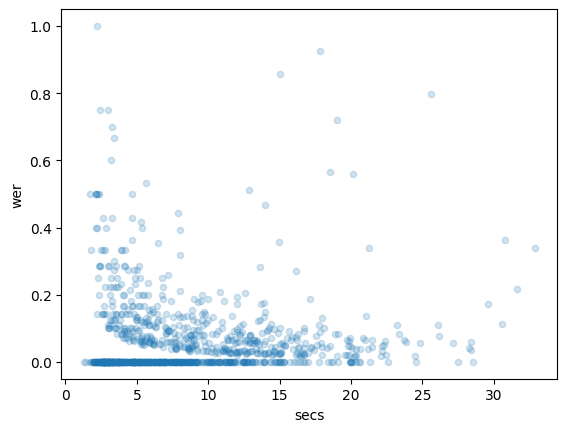

In [ ]:
_9.plot.scatter('secs', 'wer', alpha=.2)

In [ ]:
test_model("vq-base.en-2d-4096c-cosine32-padfix-premlp-preconv-learnpos-5e-cleaned.model")

WER: 6.34%


,secs,idx,gt_text,text,wer,mer,wil,wip
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, while on her lap...",0.000000,0.000000,0.000000,1.000000
696,18.415,None,FOR INSTANCE ONE DAY THE CHILDREN HAD BEEN PLA...,"For instance, one day the children had been pl...",0.000000,0.000000,0.000000,1.000000
370,2.340,None,BUT NOW NOTHING COULD HOLD ME BACK,But now nothing could hold me back.,0.000000,0.000000,0.000000,1.000000
369,9.340,None,I WANTED NOTHING MORE THAN TO SEE MY COUNTRY A...,I wanted nothing more than to see my country a...,0.000000,0.000000,0.000000,1.000000
368,6.190,None,EVEN SO I HAD JUST RETURNED FROM AN ARDUOUS JO...,"Even so, I had just returned from an arduous j...",0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...
820,2.155,None,THE FORMER BOOLOOROO GROANED,the former Boula-Ri-Growned.,0.750000,0.600000,0.800000,0.200000
843,2.110,None,FINE GLORIOUS,Find. Chlorious.,1.000000,1.000000,1.000000,0.000000
371,2.440,None,CONSEIL WAS MY MANSERVANT,Cossay was my man's servant.,1.000000,0.666667,0.833333,0.166667
592,1.805,None,HANS STIRS NOT,Hon Stir's Night.,1.333333,1.000000,1.000000,0.000000


In [ ]:
test_model("vq-base.en-2d-4096c-cosine32-padfix-premlp-premean-learnpos-5e-cleaned-repro.model")

WER: 10.00%
WER (w/o hallucinations): 10.00%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
696,18.415,None,FOR INSTANCE ONE DAY THE CHILDREN HAD BEEN PLA...,"For instance, one day the children had been pl...",0.000000,0.000000,0.000000,1.000000,False
594,4.865,None,I REFER TO THE THERMOMETER IT INDICATES THE FI...,"I refer to the thermometer, it indicates the f...",0.000000,0.000000,0.000000,1.000000,False
738,8.105,None,THEN THERE WERE THREE OR FOUR LEADING MEN OF T...,Then there were three or four leading men of t...,0.000000,0.000000,0.000000,1.000000,False
355,2.885,None,I'M AFRAID I DON'T KNOW MUCH ABOUT THE LAND OF OZ,I'm afraid I don't know much about the land of...,0.000000,0.000000,0.000000,1.000000,False
354,9.840,None,I THINK THE NEXT GLASS CAT THE MAGICIAN MAKES ...,I think the next glass cat the magician makes ...,0.000000,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
886,22.095,None,THIS MEANT THAT FOR AN ALLEGED MISDEMEANOR FOR...,This is the end of the video.,0.949153,0.949153,0.978208,0.021792,False
371,2.440,None,CONSEIL WAS MY MANSERVANT,Cossay was my man's servant.,1.000000,0.666667,0.833333,0.166667,False
85,2.610,None,THIS EVENING THEY ALL SAID,This is the end of the video.,1.200000,0.857143,0.971429,0.028571,False
538,2.215,None,STEPHANOS DEDALOS,Stefano Staedt-Loss,1.500000,1.000000,1.000000,0.000000,False


In [ ]:
test_model("vq-base.en-2d-4096c-cosine32-padfix-premlp-premean-learnpos-5e-cleaned-repro.model")

WER: 7.82%
WER (w/o hallucinations): 7.82%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
709,2.440,None,THE THREE MODES OF MANAGEMENT,the three modes of management.,0.000000,0.000000,0.000000,1.000000,False
740,2.715,None,BUT I MEAN TO HAVE MY INNINGS BEFORE LONG,But I mean to have my innings before long.,0.000000,0.000000,0.000000,1.000000,False
362,5.335,None,SOMETIMES IT IS CALLED A CRAZY QUILT BECAUSE T...,Sometimes it is called a crazy quilt because t...,0.000000,0.000000,0.000000,1.000000,False
361,6.045,None,A BED QUILT MADE OF PATCHES OF DIFFERENT KINDS...,A bed quilt made of patches of different kinds...,0.000000,0.000000,0.000000,1.000000,False
605,6.305,None,A SUFFOCATING SMELL OF NITROGEN FILLS THE AIR ...,A suffocating smell of nitrogen fills the air....,0.000000,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
793,14.580,None,IN A SUNSET GLOWING OF CRIMSON AND GOLD SHE LI...,In a sunset,0.906250,0.906250,0.906250,0.093750,False
170,8.740,None,RUTH WAS GLAD TO HEAR THAT PHILIP HAD MADE A P...,Ruth was,0.931034,0.931034,0.931034,0.068966,False
818,9.870,None,I'LL GLADLY DO THAT PROMISED THE NEW BOOLOOROO...,I'll,0.933333,0.933333,0.933333,0.066667,False
371,2.440,None,CONSEIL WAS MY MANSERVANT,Cosse was my man's servant.,1.000000,0.666667,0.833333,0.166667,False


In [ ]:
test_model("vq-base.en-2d-4096c-cosine32-padfix-premlp-premean-learnpos-5e-cleaned-repro-warm1000.model")

WER: 7.23%
WER (w/o hallucinations): 7.23%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
760,6.370,None,THERE CAME UPON ME A SUDDEN SHOCK WHEN I HEARD...,There came upon me a sudden shock when I heard...,0.000000,0.000000,0.000000,1.000000,False
368,6.190,None,EVEN SO I HAD JUST RETURNED FROM AN ARDUOUS JO...,"Even so, I had just returned from an arduous j...",0.000000,0.000000,0.000000,1.000000,False
586,5.515,None,THERE'S A HEAVY STORM COMING ON I CRIED POINTI...,"There's a heavy storm coming on, I cried, poin...",0.000000,0.000000,0.000000,1.000000,False
366,3.615,None,CHAPTER THREE AS MASTER WISHES,Chapter 3 As Master Wishes,0.000000,0.000000,0.000000,1.000000,False
365,5.780,None,I WILL SHOW YOU WHAT A GOOD JOB I DID AND SHE ...,"I will show you what a good job I did, and she...",0.000000,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
694,5.965,None,I EXPECT YOU HAVE BEEN A VERY GOOD GIRL ANDELL...,I,0.933333,0.933333,0.933333,0.066667,False
881,13.950,None,WE BELIEVE IN A LITERAL RESURRECTION AND AN AC...,We believe that we are the most important ones.,0.944444,0.944444,0.987654,0.012346,False
106,2.020,None,SQUEAK SQUEAK,"Quick, quick!",1.000000,1.000000,1.000000,0.000000,False
371,2.440,None,CONSEIL WAS MY MANSERVANT,Cossay was my man's servant.,1.000000,0.666667,0.833333,0.166667,False


In [ ]:
test_model("vq-base.en-2d-4096c-cosine32-padfix-premlp-premean-learnpos-5e-cleaned-repro-warm1000-2.model")

WER: 6.47%
WER (w/o hallucinations): 6.47%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, while on her lap...",0.0,0.000000,0.000000,1.000000,False
702,14.175,None,AND THIS METHOD OF TREATING THE CASE WAS MUCH ...,And this method of treating the case was much ...,0.0,0.000000,0.000000,1.000000,False
703,4.775,None,NATURE OF THE EFFECT PRODUCED BY EARLY IMPRESS...,Nature of the Effect produced by Early Impress...,0.0,0.000000,0.000000,1.000000,False
377,3.910,None,HE WENT HERE THERE AND EVERYWHERE IN PERFECT C...,"He went here, there, and everywhere in perfect...",0.0,0.000000,0.000000,1.000000,False
376,8.340,None,NEVER DID HE OBJECT TO BUCKLING UP HIS SUITCAS...,Never did he object to buckling up his suitcas...,0.0,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
371,2.440,None,CONSEIL WAS MY MANSERVANT,Cossé was my man's servant.,1.0,0.666667,0.833333,0.166667,False
322,3.200,None,I NOW USE THEM AS ORNAMENTAL STATUARY IN MY GA...,and,1.0,1.000000,1.000000,0.000000,False
652,3.475,None,I AM SO VERY TIRED OF BEING ALL ALONE HERE,and,1.0,1.000000,1.000000,0.000000,False
555,5.815,None,BUT THE DUSK DEEPENING IN THE SCHOOLROOM COVER...,and,1.0,1.000000,1.000000,0.000000,False


In [ ]:
test_model("vq-base.en-2d-4096c-cosine32-padfix-premlp-premean-learnpos-5e-cleaned.model")

WER: 5.93%
WER (w/o hallucinations): 5.93%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
781,3.050,None,WHEN DO YOU INTEND THAT THE JOHN BRIGHT SHALL ...,When do you intend that the John Bright shall ...,0.000000,0.000000,0.000000,1.000000,False
388,2.355,None,WE'RE LEAVING ON THE ABRAHAM LINCOLN,We're leaving on the Abraham Lincoln.,0.000000,0.000000,0.000000,1.000000,False
387,2.735,None,A ROUTE SLIGHTLY LESS DIRECT THAT'S ALL,a route slightly less direct. That's all.,0.000000,0.000000,0.000000,1.000000,False
386,5.915,None,YES WE ARE CERTAINLY I REPLIED EVASIVELY BUT A...,"Yes, we are. Certainly, I replied evasively, b...",0.000000,0.000000,0.000000,1.000000,False
385,4.530,None,ANYHOW WE'LL LEAVE INSTRUCTIONS TO SHIP THE WH...,"Anyhow, we'll leave instructions to ship the w...",0.000000,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
524,3.195,None,BROTHER MAC ARDLE BROTHER KEOGH,"Brother McCarle, Brother Kioff.",0.600000,0.600000,0.800000,0.200000,False
592,1.805,None,HANS STIRS NOT,Hans-Stirrsnacht.,0.666667,0.666667,0.833333,0.166667,False
766,2.540,None,YOU PROPOSE TO KIDNAP ME I SAID,You proposed a kenatmi set.,0.857143,0.857143,0.971429,0.028571,False
538,2.215,None,STEPHANOS DEDALOS,Steffano Staedalus,1.000000,1.000000,1.000000,0.000000,False


(0.0, 1.5)

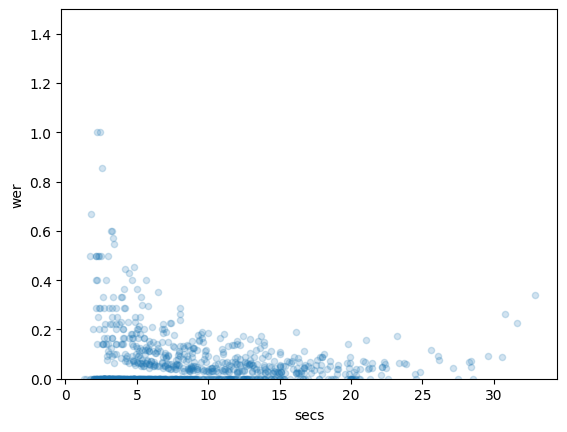

In [ ]:
ax = _14.plot.scatter('secs', 'wer', alpha=.2)
ax.set_ylim(0, 1.5)

In [ ]:
test_model("vq-base.en-2d-4096c-60k.model")

WER: 9.34%


,secs,idx,gt_text,text,wer,mer,wil,wip
646,3.385,None,I ALMOST THINK I CAN REMEMBER FEELING A LITTLE...,I almost think I can remember feeling a little...,0.000000,0.000000,0.000000,1.000000
862,6.720,None,TO THE FERVENT LATTER DAY SAINT A TEMPLE IS NO...,"To the fervent Latter-day Saint, a temple is n...",0.000000,0.000000,0.000000,1.000000
370,2.340,None,BUT NOW NOTHING COULD HOLD ME BACK,But now nothing could hold me back.,0.000000,0.000000,0.000000,1.000000
369,9.340,None,I WANTED NOTHING MORE THAN TO SEE MY COUNTRY A...,I wanted nothing more than to see my country a...,0.000000,0.000000,0.000000,1.000000
368,6.190,None,EVEN SO I HAD JUST RETURNED FROM AN ARDUOUS JO...,"Even so, I had just returned from an arduous j...",0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...
61,10.250,None,IN WINTER WHEN THE SNOW LAY GLITTERING ON THE ...,"In winter, when the snow lay glittering on the...",1.791667,0.651515,0.666035,0.333965
468,12.250,None,I HAVE GREAT THINGS TO TELL YOU SENOR SAID DON...,"I have great things to tell you, Senor, sadona...",1.861111,0.676768,0.712682,0.287318
558,15.720,None,IT WAS STRANGE TOO THAT HE FOUND AN ARID PLEAS...,"It was strange, too, that he found an arid ple...",2.317073,0.698529,0.698529,0.301471
770,13.960,None,WHAT WORLD WIDE INIQUITY SUCH A SPEECH AS THAT...,What worldwide iniquity such a speech as that ...,2.375000,0.719697,0.738740,0.261260


In [ ]:
test_model("vq-base.en-2d-4096c-cosine32-padfix-premlp-premean-learnpos-5e-cleaned-eqvad.model")

WER: 7.47%


,secs,idx,gt_text,text,wer,mer,wil,wip
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, while on her lap...",0.000000,0.000000,0.000000,1.000000
673,12.130,None,THE PRINCESS CERTAINLY WAS BEAUTIFUL AND HE WO...,"The princess certainly was beautiful, and he w...",0.000000,0.000000,0.000000,1.000000
674,2.295,None,HE ONLY SHOOK HIS HEAD,He only shook his head.,0.000000,0.000000,0.000000,1.000000
355,2.885,None,I'M AFRAID I DON'T KNOW MUCH ABOUT THE LAND OF OZ,I'm afraid I don't know much about the land of...,0.000000,0.000000,0.000000,1.000000
353,5.870,None,THE FIRST LOT WE TESTED ON OUR GLASS CAT WHICH...,"The first lot we tested on our glass cat, whic...",0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...
371,2.440,None,CONSEIL WAS MY MANSERVANT,Cossay was my man's servant.,1.000000,0.666667,0.833333,0.166667
538,2.215,None,STEPHANOS DEDALOS,Stefano Stettelos.,1.000000,1.000000,1.000000,0.000000
592,1.805,None,HANS STIRS NOT,"Honsters, nod.",1.000000,1.000000,1.000000,0.000000
146,3.260,None,WHERE THEE AND THY FAMILY ARE KNOWN,Where's D and I-F where's D and I-F are known?,1.428571,0.714286,0.836735,0.163265


(0.0, 1.5)

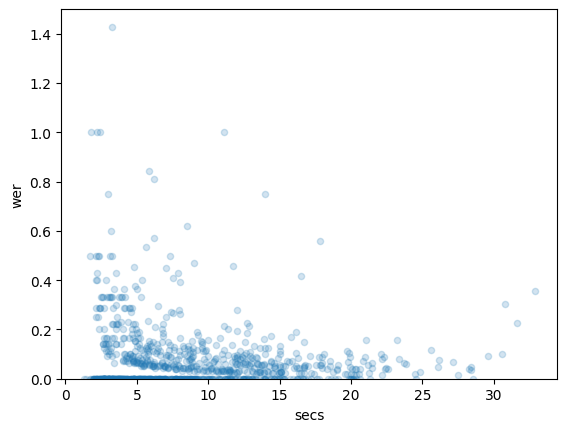

In [ ]:
ax = _8.plot.scatter('secs', 'wer', alpha=.2)
ax.set_ylim(0, 1.5)

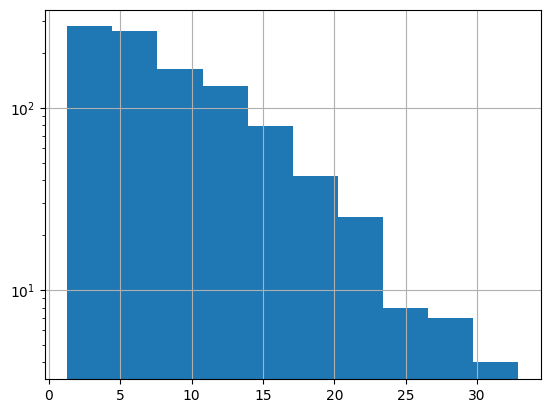

In [ ]:
ax = _15['secs'].hist()
ax.set_yscale('log')

[<matplotlib.lines.Line2D>]

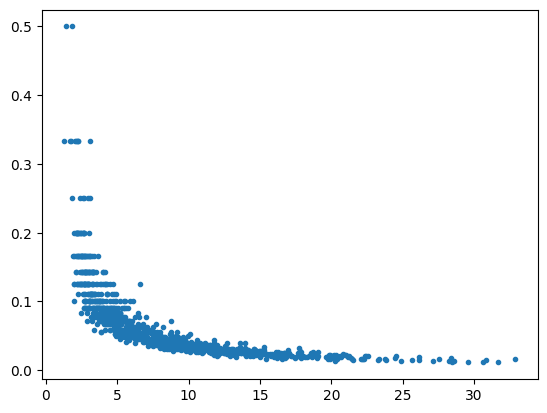

In [ ]:
plt.plot(_15['secs'], 1/_15['gt_text'].str.split('\w+').str.len(), '.')

In [ ]:
# the reproducibility got pretty low ;)
for i in range(4):
    print(i)
    test_model(f"test-run-{i}.model")
    print()

0


WER: 6.37%
WER (w/o hallucinations): 6.37%

1


WER: 10.69%
WER (w/o hallucinations): 9.89%

2


WER: 12.34%
WER (w/o hallucinations): 11.79%

3


WER: 15.83%
WER (w/o hallucinations): 15.30%



In [ ]:
test_model("test-run-warm1000.model")

WER: 8.81%
WER (w/o hallucinations): 8.81%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, while on her lap...",0.000000,0.000000,0.000000,1.000000,False
368,6.190,None,EVEN SO I HAD JUST RETURNED FROM AN ARDUOUS JO...,"Even so, I had just returned from an arduous j...",0.000000,0.000000,0.000000,1.000000,False
691,4.985,None,TO GIVE AN IDEA OF THESE CONVERSATIONS I WILL ...,"To give an idea of these conversations, I will...",0.000000,0.000000,0.000000,1.000000,False
366,3.615,None,CHAPTER THREE AS MASTER WISHES,Chapter 3 As Master Wishes,0.000000,0.000000,0.000000,1.000000,False
365,5.780,None,I WILL SHOW YOU WHAT A GOOD JOB I DID AND SHE ...,"I will show you what a good job I did, and she...",0.000000,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
792,1.810,None,VENICE,VINIS.,1.000000,1.000000,1.000000,0.000000,False
324,2.700,None,ASKED THE VOICE IN SCORNFUL ACCENTS,Ask the voice in the voice in the voice in the...,1.500000,0.750000,0.875000,0.125000,False
538,2.215,None,STEPHANOS DEDALOS,Stefano's dead loss.,2.000000,1.000000,1.000000,0.000000,False
26,16.735,None,P S PRAY SIR EXCUSE ME FOR WRITING TO YOU A SE...,P-S-P-S-P-S-P-S-P-S-P-S-P-S-P-S-P-S-P-S-P-S-P-...,2.037037,0.982143,0.999339,0.000661,False


In [ ]:
test_model("test-run-1e.model")

WER: 8.41%
WER (w/o hallucinations): 8.05%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, while on her lap...",0.000000,0.000000,0.000000,1.000000,False
655,4.895,None,I SHALL BE PUNISHED FOR IT NOW I SUPPOSE BY BE...,"I shall be punished for it now, I suppose, by ...",0.000000,0.000000,0.000000,1.000000,False
657,3.640,None,I AM VERY TIRED OF SWIMMING ABOUT HERE O MOUSE,"I am very tired of swimming about here, oh mouse.",0.000000,0.000000,0.000000,1.000000,False
318,5.115,None,MOST PEOPLE TALK TOO MUCH SO IT IS A RELIEF TO...,"Most people talk too much, so it is a relief t...",0.000000,0.000000,0.000000,1.000000,False
317,7.920,None,HE SELECTED A SMALL GOLD BOTTLE WITH A PEPPER ...,He selected a small gold bottle with a pepper ...,0.000000,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
549,10.575,None,AT MOST BY AN ALMS GIVEN TO A BEGGAR WHOSE BLE...,"At most, by an alms given to a beggar whose bl...",1.000000,0.500000,0.500000,0.500000,True
399,6.365,None,I WAS WELL SATISFIED WITH MY CABIN WHICH WAS L...,"I was well satisfied with my cabin, which was ...",1.052632,0.540541,0.588905,0.411095,False
538,2.215,None,STEPHANOS DEDALOS,Steffinor's Daedalus.,1.500000,1.000000,1.000000,0.000000,False
659,4.995,None,WE WON'T TALK ABOUT HER ANY MORE IF YOU'D RATH...,We won't talk about her anymore if he'd rather...,1.866667,0.700000,0.760000,0.240000,True


In [ ]:
# but it got better after some hyperparam tuning
test_model("vqmodel-4e-6454-hyptuned.model")

WER: 7.71%
WER (w/o hallucinations): 7.71%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
403,5.370,None,DEPARTING FROM FIVE HUNDRED THOUSAND THROATS T...,"Departing from 500,000 throats, three cheers b...",0.000000,0.000000,0.000000,1.000000,False
922,4.400,None,BUT HOW DID SHE MANAGE TO RENDER IT SO FASHION...,But how did she manage to render it so fashion...,0.000000,0.000000,0.000000,1.000000,False
629,3.235,None,TWO HOURS AFTERWARDS A TERRIBLE SHOCK AWOKE ME,"Two hours afterwards, a terrible shock, awoke me.",0.000000,0.000000,0.000000,1.000000,False
355,2.885,None,I'M AFRAID I DON'T KNOW MUCH ABOUT THE LAND OF OZ,I'm afraid I don't know much about the land of...,0.000000,0.000000,0.000000,1.000000,False
353,5.870,None,THE FIRST LOT WE TESTED ON OUR GLASS CAT WHICH...,"The first lot we tested on our glass cat, whic...",0.000000,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
849,3.560,None,I HAD A NOTION IT WAS YOU MATE AS SAVED ME FRO...,I'll have a note.,0.928571,0.866667,0.942857,0.057143,False
741,16.360,None,OF WHAT MISSUS NEVERBEND HAD GONE THROUGH IN P...,Of what Mrs. N N N N N N N N N N N N N N N N N...,0.936170,0.936170,0.992021,0.007979,False
371,2.440,None,CONSEIL WAS MY MANSERVANT,Casa was my man's servant.,1.000000,0.666667,0.833333,0.166667,False
538,2.215,None,STEPHANOS DEDALOS,Stefano Stetelos.,1.000000,1.000000,1.000000,0.000000,False


In [ ]:
test_model("vqmodel-4e-6454-hyptuned-small.en.model", N=1000)

WER: 7.38%
WER (w/o hallucinations): 7.38%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, while on her lap...",0.00000,0.000000,0.000000,1.000000,False
350,10.680,None,AT ONE END STOOD A GREAT FIREPLACE IN WHICH A ...,"At one end stood a great fireplace, in which a...",0.00000,0.000000,0.000000,1.000000,False
349,2.130,None,THE WOMAN SEEMED THOUGHTFUL,The woman seemed thoughtful.,0.00000,0.000000,0.000000,1.000000,False
680,6.450,None,HE DARTED LIKE AN ARROW THROUGH ALL THE HALLS ...,"He darted like an arrow through all the halls,...",0.00000,0.000000,0.000000,1.000000,False
347,3.665,None,OJO HAD NEVER EATEN SUCH A FINE MEAL IN ALL HI...,Ojo had never eaten such a fine meal in all hi...,0.00000,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
592,1.805,None,HANS STIRS NOT,"Honsters, Nod.",1.00000,1.000000,1.000000,0.000000,False
792,1.810,None,VENICE,VINUS.,1.00000,1.000000,1.000000,0.000000,False
371,2.440,None,CONSEIL WAS MY MANSERVANT,Cossay was my man's servant.,1.00000,0.666667,0.833333,0.166667,False
538,2.215,None,STEPHANOS DEDALOS,Stephenos dead loss.,1.50000,1.000000,1.000000,0.000000,False


In [ ]:
test_model("vqmodel-4e-hyptuned-16gpu.model", N=1000)

WER: 6.01%
WER (w/o hallucinations): 6.01%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, while on her lap...",0.000000,0.000000,0.000000,1.000000,False
390,1.975,None,WE DON'T KNOW WHERE IT WILL TAKE US,We don't know where it will take us.,0.000000,0.000000,0.000000,1.000000,False
708,13.020,None,THE PAIN PRODUCED BY AN ACT OF HASTY AND ANGRY...,The pain produced by an act of hasty and angry...,0.000000,0.000000,0.000000,1.000000,False
388,2.355,None,WE'RE LEAVING ON THE ABRAHAM LINCOLN,We're leaving on the Abraham Lincoln.,0.000000,0.000000,0.000000,1.000000,False
387,2.735,None,A ROUTE SLIGHTLY LESS DIRECT THAT'S ALL,"A route slightly less direct, that's all.",0.000000,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
918,3.000,None,THAT IS TRUE BADAUDERIE,"That is true, bad old gree.",0.750000,0.500000,0.625000,0.375000,False
809,8.875,None,WHEN THE BLUESKINS SAW GHIP GHISIZZLE THEY RAI...,Thanks for watching!,0.961538,0.961538,0.987179,0.012821,False
643,12.020,None,ALICE TOOK UP THE FAN AND GLOVES AND AS THE HA...,Thank you.,1.000000,1.000000,1.000000,0.000000,False
371,2.440,None,CONSEIL WAS MY MANSERVANT,Cosse was my man's servant.,1.000000,0.666667,0.833333,0.166667,False


In [ ]:
test_model("vqmodel-4e-hyptuned-32gpu.model", N=1000)

WER: 5.94%
WER (w/o hallucinations): 5.94%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
757,10.030,None,THEREFORE I FEEL MYSELF QUITE ABLE AS PRESIDEN...,"Therefore, I feel myself quite able, as Presid...",0.00,0.000000,0.000000,1.000000,False
628,2.550,None,DURING HIS WATCH I SLEPT,"During his watch, I slept.",0.00,0.000000,0.000000,1.000000,False
756,4.735,None,YOU HAVE COME TO US THREATENING US WITH ABSOLU...,You have come to us threatening us with absolu...,0.00,0.000000,0.000000,1.000000,False
377,3.910,None,HE WENT HERE THERE AND EVERYWHERE IN PERFECT C...,"He went here, there, and everywhere in perfect...",0.00,0.000000,0.000000,1.000000,False
376,8.340,None,NEVER DID HE OBJECT TO BUCKLING UP HIS SUITCAS...,Never did he object to buckling up his suitcas...,0.00,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
918,3.000,None,THAT IS TRUE BADAUDERIE,That is true bad-delt gree.,0.75,0.500000,0.625000,0.375000,False
371,2.440,None,CONSEIL WAS MY MANSERVANT,Cossay was my man's servant.,1.00,0.666667,0.833333,0.166667,False
592,1.805,None,HANS STIRS NOT,Honsters Nied.,1.00,1.000000,1.000000,0.000000,False
819,5.775,None,SCUSE ME SAID TROT I NEGLECTED TO TELL YOU THA...,Thanks for watching.,1.00,1.000000,1.000000,0.000000,False


In [ ]:
test_model("vqmodel-512c-4e-hyptuned-32gpu.model", N=1000)

WER: 7.37%
WER (w/o hallucinations): 7.37%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
715,11.340,None,THE MOTHER IN MANAGING THE CASE IN THIS WAY RE...,"The mother, in managing the case in this way, ...",0.0,0.000000,0.000000,1.000000,False
347,3.665,None,OJO HAD NEVER EATEN SUCH A FINE MEAL IN ALL HI...,Ojo had never eaten such a fine meal in all hi...,0.0,0.000000,0.000000,1.000000,False
860,10.555,None,IT IS NOTABLE THAT THE INDIAN TRIBES HAVE GENE...,It is notable that the Indian tribes have gene...,0.0,0.000000,0.000000,1.000000,False
608,3.070,None,THE HORIZON SEEMS EXTREMELY DISTANT,The horizon seems extremely distant.,0.0,0.000000,0.000000,1.000000,False
344,4.275,None,I AM MY DEAR AND ALL STRANGERS ARE WELCOME TO ...,"I am, my dear, and all strangers are welcome t...",0.0,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
371,2.440,None,CONSEIL WAS MY MANSERVANT,Cosay was my man's servant.,1.0,0.666667,0.833333,0.166667,False
260,3.155,None,WHO TAUGHT YOU TO SCRUB A FLOOR I SHOULD LIKE ...,.,1.0,1.000000,1.000000,0.000000,False
592,1.805,None,HANS STIRS NOT,Honster's Night.,1.0,1.000000,1.000000,0.000000,False
792,1.810,None,VENICE,Venus.,1.0,1.000000,1.000000,0.000000,False


In [ ]:
test_model("vqmodel-512c-dim64-4e-hyptuned-32gpu.model", N=1000)

WER: 7.13%
WER (w/o hallucinations): 7.13%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, while on her lap...",0.000000,0.000000,0.000000,1.000000,False
680,6.450,None,HE DARTED LIKE AN ARROW THROUGH ALL THE HALLS ...,"He darted like an arrow through all the halls,...",0.000000,0.000000,0.000000,1.000000,False
682,5.145,None,AND ALL HIS BROTHERS AND SISTERS STOOD ROUND A...,and all his brothers and sisters stood round a...,0.000000,0.000000,0.000000,1.000000,False
684,2.165,None,ANDERS FACE GREW RED,Anders face grew red.,0.000000,0.000000,0.000000,1.000000,False
685,2.775,None,BUT HIS MOTHER HUGGED HIM CLOSE,But his mother hugged him close.,0.000000,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
106,2.020,None,SQUEAK SQUEAK,"Speak, speak.",1.000000,1.000000,1.000000,0.000000,False
371,2.440,None,CONSEIL WAS MY MANSERVANT,Cossay was my man's servant.,1.000000,0.666667,0.833333,0.166667,False
592,1.805,None,HANS STIRS NOT,"Honsters, Nied.",1.000000,1.000000,1.000000,0.000000,False
336,4.835,None,FOR A LONG TIME HE HAD WISHED TO EXPLORE THE B...,"For a long time, you can see that the video is...",1.333333,0.800000,0.933333,0.066667,False


In [ ]:
test_model("vqmodel-base-en+pl-512c-dim64.model", N=1000)

WER: 8.45%
WER (w/o hallucinations): 8.45%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, while on her lap...",0.0,0.0,0.0,1.0,False
740,2.715,None,BUT I MEAN TO HAVE MY INNINGS BEFORE LONG,But I mean to have my innings before long.,0.0,0.0,0.0,1.0,False
387,2.735,None,A ROUTE SLIGHTLY LESS DIRECT THAT'S ALL,"A route slightly less direct, that's all.",0.0,0.0,0.0,1.0,False
386,5.915,None,YES WE ARE CERTAINLY I REPLIED EVASIVELY BUT A...,"Yes, we are, certainly, I replied evasively, b...",0.0,0.0,0.0,1.0,False
744,3.630,None,WHAT COULD I DO NOW BUT JUST LAY MYSELF DOWN A...,"What could I do now, but just lay myself down ...",0.0,0.0,0.0,1.0,False
...,...,...,...,...,...,...,...,...,...
114,6.560,None,YES IN REALITY THOSE WERE HAPPY TIMES,Thank you.,1.0,1.0,1.0,0.0,False
191,5.580,None,WHY IT'S IN MISSOURI SOMEWHERE ON THE FRONTIER...,Thank you.,1.0,1.0,1.0,0.0,False
538,2.215,None,STEPHANOS DEDALOS,Stefano Stedilos,1.0,1.0,1.0,0.0,False
16,1.695,None,FAREWELL MADAM,"Fair Well, Madame.",1.5,1.0,1.0,0.0,False


In [ ]:
test_model("vqmodel-medium-en+pl-512c-dim64.model", N=1000)

WER: 7.34%
WER (w/o hallucinations): 6.62%


,secs,idx,gt_text,text,wer,mer,wil,wip,hallucination
0,8.230,None,AND OFTEN HAS MY MOTHER SAID WHILE ON HER LAP ...,"And often has my mother said, While on her lap...",0.000000,0.000000,0.000000,1.000000,False
571,6.615,None,STEPHEN'S HEART BEGAN SLOWLY TO FOLD AND FADE ...,Stephen's heart began slowly to fold and fade ...,0.000000,0.000000,0.000000,1.000000,False
572,4.090,None,HE IS CALLED AS YOU KNOW THE APOSTLE OF THE IN...,"He is called, as you know, the Apostle of the ...",0.000000,0.000000,0.000000,1.000000,False
573,3.330,None,A GREAT SAINT SAINT FRANCIS XAVIER,"A great saint, St. Francis Xavier.",0.000000,0.000000,0.000000,1.000000,False
575,3.445,None,HE HAD THE FAITH IN HIM THAT MOVES MOUNTAINS,He had the faith in him that moves mountains.,0.000000,0.000000,0.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...
76,4.110,None,REJOICE IN THY OWN FRESH YOUTH,Read more at www.BritishMedia.com,1.000000,1.000000,1.000000,0.000000,False
63,13.950,None,TO GROW AND GROW TO GET OLDER AND BE TALL THOU...,. . . . . . . . . . . . . . . . . . . . . . . ...,1.000000,1.000000,1.000000,0.000000,False
819,5.775,None,SCUSE ME SAID TROT I NEGLECTED TO TELL YOU THA...,Thanks for watching!,1.000000,1.000000,1.000000,0.000000,False
95,8.800,None,THOUGHT THE FIR TREE AND BELIEVED IT ALL BECAU...,"thought the fur tree, and believed it all, bec...",2.047619,0.682540,0.697657,0.302343,False


In [ ]:
def show_stat(stats, i):
    row = stats.loc[i]
    print('WER: ', row['wer'])
    print('GT:  ', row['gt_text'])
    print('GEN: ', row['text'])

In [ ]:
show_stat(_18, 654)

WER:  6.9
GT:   I WISH I HADN'T CRIED SO MUCH SAID ALICE AS SHE SWAM ABOUT TRYING TO FIND HER WAY OUT
GEN:  "'I wish I hadn't cried so much,' said Alice, as she swam about, trying to find her way out. "'I wish I hadn't cried so much,' said Alice, as she swam about, trying to find her way out. "'I wish I hadn't cried so much,' said Alice, as she swam about, trying to find her way out. "'I wish I hadn't cried so much,' said Alice, as she swam about, trying to find her way out. "'I wish I hadn't cried so much,' said Alice, as she swam about, trying to find her way out. "'I wish I hadn't cried so much,' said Alice, as she swam about, trying to find her way out. "'I wish I hadn't cried so much,' said Alice, as she swam about, trying to find her way out. "'I wish I hadn't cried so much,' said Alice, as she swam about, trying to find her


In [ ]:
show_stat(_18, 819)

WER:  1.0
GT:   SCUSE ME SAID TROT I NEGLECTED TO TELL YOU THAT YOU'RE NOT THE BOOLOOROO ANY MORE
GEN:  Thanks for watching!


In [ ]:
show_stat(_13, 114)

WER:  1.0
GT:   YES IN REALITY THOSE WERE HAPPY TIMES
GEN:  Thank you.


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()